# LUNAR LANDER v2 Solved with a DQN

## Installing All Dependencies

In [1]:
%config IPCompleter.use_jedi = False

import gym
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

### Visualization Utility

Taken from [this GitHub gist](https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553).

In [2]:
from matplotlib import animation


def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1], frames[0].shape[0]))

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename)

## Instantiating All Required Objects

Four objects need to be instantiated at this point:
1. **The Environment**
2. **The Agent**
    1. *Hyperparameters*
    2. *DQN*

The agent itself is defined in the `Agent` class in the file `dqn_agent.py` in the parent folder. The agent differs from the one described in the original DQN paper in that it doesn't update the target DQN after a fixed number of steps. Instead, it continuously performs soft updates of the target DQN with the weights from the current DQN.

The architecture of the DQNs that the agent internally instantiates is defined in the `model.py` file in this directory. This too, was determined through trial-and-error, but I have tried to make it as small as possible.

The default hyperparameters are defined in the `HyperparameterConfig` class in the file `dqn_agent.py` in the parent directory:

```
        self.EPS_START = 1.0
        self.EPS_END = 0.01
        self.EPS_DECAY = 0.995
        
        self.BUFFER_SIZE = int(1e5)  # replay buffer size
        self.GAMMA = 0.99            # discount factor

        self.BATCH_SIZE = 64         # minibatch size
        self.LR = 5e-4               # learning rate 
        self.UPDATE_EVERY = 4        # how often to the current DQN should learn
        
        self.HARD_UPDATE = False     # to hard update or not (with double DQN, one should)
        self.DOUBLE_DQN = False      # to use double DQN or not
        self.TAU = 1e-3              # for soft update of target parameters
        self.OVERWRITE_EVERY = 128   # how often to clone the local DQN to the target DQN
```

The overridden values can be found in the following code cell. These hyperparameters were determined through trial-and-error.

In [3]:
import sys
sys.path.insert(0,'..')

from dqn_agent import HyperparameterConfig, Agent
from model import SimpleDQN


# Set Hyperparameters
hp = HyperparameterConfig()
hp.BUFFER_SIZE = int(1e4)
hp.BATCH_SIZE = 128
hp.DOUBLE_DQN = True
hp.HARD_UPDATE = True
hp.OVERWRITE_EVERY = 64

# Instantiate environment
env = gym.make('LunarLander-v2')
env.seed(0)

# Instantiate agent
agent = Agent(
    state_size=env.observation_space.shape[0], 
    action_size=env.action_space.n, 
    seed=0,
    QNetwork=SimpleDQN, 
    hyperparameters=hp
)

## Visualizing the Random Agent

In [ ]:
frames = []
for i in range(5):
    state = env.reset()
    for t in range(500):
        action = env.action_space.sample()
        frames.append(env.render(mode="rgb_array"))
        state, _, done, _ = env.step(action)
        if done:
            break

env.close()
save_frames_as_gif(frames, path='./videos/', filename='random_agent.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


## Training the Agent

A running average of the return over the last 100 episodes is maintained and plotted at the end. The training ends once the running average crosses 200.

Every episode has an upper limit of 1500 steps (that's quite generous for the LunarLander-v2 environment, actually)

Episode 100	Average Score: -170.40
Episode 200	Average Score: -68.425
Episode 300	Average Score: 49.585
Episode 400	Average Score: 166.98
Episode 426	Average Score: 200.59
Environment solved in 426 episodes!	Average Score: 200.59


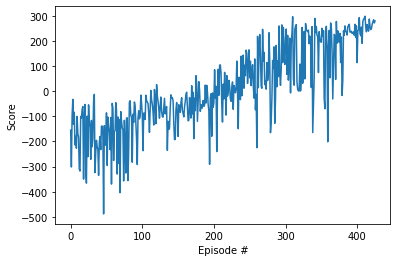

In [15]:
def dqn(
    n_episodes=2000,
    max_t=1500,
    eps_start=hp.EPS_START,
    eps_end=hp.EPS_END,
    eps_decay=hp.EPS_DECAY
):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.current_dqn.state_dict(), 'trained_dqn.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Visualizing and Saving a GIF of the Trained Agent

MovieWriter imagemagick unavailable; using Pillow instead.


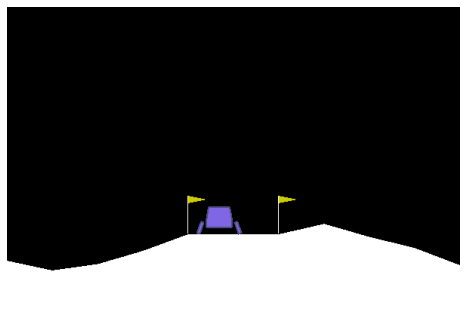

In [10]:
agent.current_dqn.load_state_dict(torch.load('trained_dqn.pth'))

frames = []
for i in range(5):
    state = env.reset()
    for t in range(500):
        action = agent.act(state)
        frames.append(env.render(mode="rgb_array"))
        state, _, done, _ = env.step(action)
        if done:
            break

env.close()
save_frames_as_gif(frames, path='./videos/', filename='trained_agent.gif')